In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 118.2 MB/s eta 0:00:00


In [ ]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


<Figure size 432x288 with 0 Axes>

## Custom functions definition:

In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

# Loading the data

In [ ]:
dff = pd.read_csv('/content/drive/MyDrive/annotated_3cat_3_random.csv')

In [ ]:
dff.dropna(inplace=True)
dff

,text,Sentiment
0,Bitcoin is unfolding like the dot com crash ju...,Neutral
1,XEM Price is 0 00003330 0 00000044 BTC 0 28641...,Negative
2,RT Bitcoin daily snapshot 24hr CHANGE 6 4 OUTL...,Neutral
3,Dutch Court Finds Bitcoin A Legitimate Transfe...,Neutral
4,BTC STEEM AskRate 0 00024274 Bittrex STEEM STE...,Positive
...,...,...
25098,The Image MASSter Solo 101 Forensic Hard Drive...,Negative
25099,Buy Bitcoin Bitcoin Cash Monero Zcash or Litec...,Positive
25100,In April 2016 computer technicians at the Demo...,Neutral
25101,The Gentlemen of Crypto EP 129 Bitcoin Blackli...,Neutral


In [ ]:
df, df_test = train_test_split(dff, random_state=42, test_size=0.1)

In [ ]:
df

,text,Sentiment
16432,RT A new survey of Americans has shown that cr...,Positive
7614,Fantatic,Neutral
3789,64 How to get started with google adsense affi...,Neutral
24483,RT New post Leaked Documents Reveals NSA Attem...,Positive
18080,AtlantaCyberAttack WHAT IN THE WORLD IS GOING ON,Neutral
...,...,...
21576,Also,Negative
5391,RT Japan s electric power provider partnered w...,Neutral
860,Bitcoin BTG OFFICIAL Bitcoin Gold go becomes p...,Positive
15796,Block Number 577 049 Time 5 21 2019 7 13 14 AM...,Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22590 entries, 16432 to 23656
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       22590 non-null  object
 1   Sentiment  22590 non-null  object
dtypes: object(2)
memory usage: 529.5+ KB


# Tweets Cleaning

In [ ]:
#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [ ]:
texts_new = []
for t in df.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

In [ ]:
texts_new_test = []
for t in df_test.text:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

new column with the clean tweets

In [ ]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [ ]:
df['text_clean'].head()

16432    rt a new survey of americans has shown that cr...
7614                                              fantatic
3789     64 how to get started with google adsense affi...
24483    rt new post leaked documents reveals nsa attem...
18080     atlantacyberattack what in the world is going on
Name: text_clean, dtype: object

In [ ]:
df_test['text_clean'].head()

7331     20 for free registering to binance 0 1 trading...
9623     name wings symbol wings 24 hour change 8 37 pr...
15176                              thread this guy gets it
6831     the latest the cryptopia daily thanks to bitco...
23469                                facts and bitcoin lol
Name: text_clean, dtype: object

In [ ]:
df['text_clean'][1:8].values

array(['fantatic',
       '64 how to get started with google adsense affiliatemarketing bitcoin affiliatemarketing onlinemarketing',
       'rt new post leaked documents reveals nsa attempt to crack bitcoin users identity has been published on sgt report',
       'atlantacyberattack what in the world is going on',
       'capuchincrypt who lost money in bitcoin',
       'bitcoin spike sparks crypto jacking trend by rt com',
       'breaking news binance will be listing wan wan soon cryptocurrency blockchain bitcoin crypto btc ico eth xrp trading cryptonews'],
      dtype=object)

finding the length of the texts to check whether the cleaning caused any null texts

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df['text_len'] = text_len

In [ ]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [ ]:
df_test['text_len'] = text_len_test

In [ ]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (22590, 4)
 DF TEST SHAPE: (2511, 4)


In [ ]:
df = df[df['text_len'] > 4]

In [ ]:
df_test = df_test[df_test['text_len'] > 4]

In [ ]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (21785, 4)
 DF TEST SHAPE: (2423, 4)


## Training data deeper cleaning

Importing the RoBERTa tokenizer.

In [ ]:
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
from transformers import AutoTokenizer, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment-latest')

In [ ]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 110


checking the long tokenized sentences (with more than 80 tokens ):

In [ ]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 1543, TEXT: check all here gt on poloniex ppc to btc gt 0 00005036 volume gt 24426 on bittrex ltc to btc gt 0 01148535 volume gt 64437 on exmo xmr to btc gt 0 01116881 volume gt 985 on hitbtc xrp to btc gt 0 00004997 volume gt 59295632
INDEX: 4454, TEXT: wish smart contract amp distribution in 24 hrs send 0 15 eth 1 500 000 wish send to eth address 0x4c70f816764a238610af3de27157a87ebb428fc5 listing on mercatox amp coinexchange follow retweet comment eth address airdrop binance xrp xvg trx btc eth iheartbts
INDEX: 4561, TEXT: zeroxripple send eth that i will send to the address you have deposited 0x3bf591107a6c7dcb8326d21d8a3340f33c72155d 1 eth 5000000 000 zeroxripple 0 9 eth 4500000 000 zeroxripple 0 8 eth 4000000 000 zeroxripple airdrop airdropalert bitcoin ethereum ripple coinhacker
INDEX: 5185, TEXT: prices in brl btc 33 825 90 32 199 65 bch 1 892 81 1 651 91 btg 117 79 92 18 dgb 0 06 0 05 dsh 783 06 653 68 eth 1 086 16 1 022 88 rbtc 34 166 79 31 563 61 realt 1 00 1 00 smart 

In [ ]:
df['token_lens'] = token_lens

<ipython-input-29-b06175d1d9b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['token_lens'] = token_lens


In [ ]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,text,Sentiment,text_clean,text_len,token_lens
3379,Prices in BRL BTC 33 825 90 32 199 65 BCH 1 89...,Negative,prices in brl btc 33 825 90 32 199 65 bch 1 89...,82,110
7041,Prices in BRL BTC 33 401 58 31 795 73 BCH 1 86...,Negative,prices in brl btc 33 401 58 31 795 73 bch 1 86...,82,110
19479,RT LBCC OSTK DIGAF MGTI BTCS BTC BCH XRP STOCK...,Negative,rt lbcc ostk digaf mgti btcs btc bch xrp stock...,43,101
2626,ZeroXRipple SEND ETH That I will send to the a...,Negative,zeroxripple send eth that i will send to the a...,37,93
12418,Check all here gt On Poloniex PPC to BTC gt 0 ...,Negative,check all here gt on poloniex ppc to btc gt 0 ...,48,93
16978,Check all here gt On Exmo BTC to EUR gt 7119 9...,Negative,check all here gt on exmo btc to eur gt 7119 9...,49,86
18663,CriptoDolar Bitcoin 22May 10 05 27 AM BTC 7 86...,Negative,criptodolar bitcoin 22may 10 05 27 am btc 7 86...,55,86
7016,Current Crypto Prices BTC 7912 26 USD ETH 251 ...,Negative,current crypto prices btc 7912 26 usd eth 251 ...,51,86
16017,CriptoDolar Bitcoin 22May 09 05 01 AM BTC 7 83...,Negative,criptodolar bitcoin 22may 09 05 01 am btc 7 83...,54,85
1844,0 05BTC gt 20BTC We need Just a Week Join BTC ...,Negative,0 05btc gt 20btc we need just a week join btc ...,47,85


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

## Test data deeper cleaning

Same operations on test set

In [ ]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 94


In [ ]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 438, TEXT: criptodolar bitcoin 21may 08 05 07 pm btc 7 957 67 usd 0 13 eth 255 34 usd 0 34 dash 166 26 usd 0 22 pab btc 8 071 47 pab usd btc 8 146 87 usd eur btc 7 245 86 eur ves btc 46 935 757 bs vesusd 5 788 bs ven
INDEX: 645, TEXT: check all here gt on kraken xmr to eur gt 79 3 volume gt 14777 on bitfinex ltc to usd gt 90 564 volume gt 368520 on incorex eth to rub gt 17056 21 volume gt 267 on c cex grc to btc gt 0 00000109 volume gt 320366
INDEX: 795, TEXT: nby being manipulated but bulls still jumping bids shes gonna run aapl goog intc amzn msft cmcsa pfe mu nflx nok xom dis hsy nvda unp bac wmt chk aks vz ctl fcx amat tsla jpm wft pti bidu mrk bitcoin cldx kgkg sipc psgr blta decn cote andi
INDEX: 1635, TEXT: wish smart contract amp distribution in 24 hrs send 0 005 eth 50 000 wish send to eth address 0x4c70f816764a238610af3de27157a87ebb428fc5 listing on mercatox amp coinexchange follow retweet comment eth address airdrop iost binance xrp xvg trx btc eth np


In [ ]:
df_test['token_lens'] = token_lens_test

In [ ]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10) 

,text,Sentiment,text_clean,text_len,token_lens
6073,NBY being MANIPULATED but bulls still jumping ...,Negative,nby being manipulated but bulls still jumping ...,49,94
22278,CriptoDolar Bitcoin 21May 08 05 07 PM BTC 7 95...,Negative,criptodolar bitcoin 21may 08 05 07 pm btc 7 95...,55,85
10697,WISH SMART CONTRACT amp DISTRIBUTION IN 24 HRS...,Negative,wish smart contract amp distribution in 24 hrs...,39,81
13015,Check all here gt On Kraken XMR to EUR gt 79 3...,Negative,check all here gt on kraken xmr to eur gt 79 3...,49,81
9252,Berita hari ini Pengkritik Bitcoin Nouriel Rou...,Negative,berita hari ini pengkritik bitcoin nouriel rou...,27,76
1450,crypto prices update 1h BTC 7384 74 0 19 ETH 2...,Negative,crypto prices update 1h btc 7384 74 0 19 eth 2...,56,75
16722,HIJOS DE LA CHINGADA NOMAS VEN QUE BTC Y RXP S...,Negative,hijos de la chingada nomas ven que btc y rxp s...,38,74
17548,BTC Bitcoin USD 7972 72 Bitcoin EUR 7143 72 Bi...,Negative,btc bitcoin usd 7972 72 bitcoin eur 7143 72 bi...,30,72
8196,1 ETH is worth 256 67 USD 0 03217 BTC 230 33 E...,Negative,1 eth is worth 256 67 usd 0 03217 btc 230 33 e...,50,69
18191,Make your money grow with CityOfInvestment We ...,Negative,make your money grow with cityofinvestment we ...,36,69


In [ ]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

# Sentiment column analysis

In [ ]:
df['Sentiment'].value_counts()

Neutral     8531
Positive    6736
Negative    6518
Name: Sentiment, dtype: int64

Labeling the sentiments

In [ ]:
df['Sentiment'] = df['Sentiment'].map({'Negative':0,'Neutral':1,'Positive':2})

In [ ]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Negative':0,'Neutral':1,'Positive':2})

In [ ]:
df['Sentiment'].value_counts()

1    8531
2    6736
0    6518
Name: Sentiment, dtype: int64

In [ ]:
df

,text,Sentiment,text_clean,text_len,token_lens
0,MinedBlock has brought to the blockchain a ver...,0,minedblock has brought to the blockchain a ver...,25,29
1,Roger McNamee Self Inflicted Wounds Are Killin...,1,roger mcnamee self inflicted wounds are killin...,12,19
2,It doesent require a new community since it al...,2,it doesent require a new community since it al...,20,23
3,RT Bitcoin Price Falls As Markets React To Fal...,0,rt bitcoin price falls as markets react to fal...,12,17
4,Use the code HF18BDAY30 at purchase to get a 3...,0,use the code hf18bday30 at purchase to get a 3...,20,27
...,...,...,...,...,...
21780,RT I liked a video Business Class Tickets With...,2,rt i liked a video business class tickets with...,10,12
21781,Earn FREE Bitcoin BTCPeek HaveBitcoin BitcoinL...,2,earn free bitcoin btcpeek havebitcoin bitcoinl...,8,20
21782,The current value of BTC at 21 24 09 on 21 05 ...,0,the current value of btc at 21 24 09 on 21 05 ...,21,27
21783,Mining 101 How To Use NiceHash To Earn Bitcoin...,2,mining 101 how to use nicehash to earn bitcoin...,21,24


To get rid of class imbalance problem, random oversampling is done.

## Class Balancing by RandomOverSampler

In [ ]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [ ]:
train_os['Sentiment'].value_counts()

0    8531
1    8531
2    8531
Name: Sentiment, dtype: int64

## Train - Validation - Test split

In [ ]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [ ]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

## One hot encoding

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 23033
VALIDATION DATA: 2560
TESTING DATA: 2423


# RoBERTa Sentiment Analysis

checking for the length of the longest tokenized sentence by roberta tokenizer:

In [ ]:
token_lens = []

for txt in X_train:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

110

In [ ]:
MAX_LEN=128

Then we can define the tokenization function

In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

# RoBERTa modeling

In [ ]:
def create_model(roberta_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len),dtype='int32')
    embedding = roberta_model([input_ids,attention_masks])[1]
    #output = output[1]
    output = tf.keras.layers.Dense(3, activation="softmax")(embedding)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [ ]:
#bert_model = TFBertModel.from_pretrained('bert-base-uncased')
roberta_model = TFAutoModel.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment-latest')

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit([train_input_ids,train_attention_masks], y_train, 
                    validation_data=([val_input_ids,val_attention_masks], y_valid), 
                    epochs=10, batch_size=32, callbacks=[early_stop])

Epoch 1/10
720/720 [==============================] - 656s 817ms/step - loss: 0.6138 - categorical_accuracy: 0.7426 - val_loss: 0.3756 - val_categorical_accuracy: 0.8578
Epoch 2/10
720/720 [==============================] - 578s 803ms/step - loss: 0.3489 - categorical_accuracy: 0.8698 - val_loss: 0.3160 - val_categorical_accuracy: 0.8898
Epoch 3/10
720/720 [==============================] - 579s 804ms/step - loss: 0.2458 - categorical_accuracy: 0.9116 - val_loss: 0.2430 - val_categorical_accuracy: 0.9176
Epoch 4/10
720/720 [==============================] - 578s 803ms/step - loss: 0.1691 - categorical_accuracy: 0.9421 - val_loss: 0.2482 - val_categorical_accuracy: 0.9242
Epoch 5/10
720/720 [==============================] - 578s 802ms/step - loss: 0.1201 - categorical_accuracy: 0.9593 - val_loss: 0.2669 - val_categorical_accuracy: 0.9312
Epoch 6/10
720/720 [==============================] - 577s 802ms/step - loss: 0.0847 - categorical_accuracy: 0.9713 - val_loss: 0.2691 - val_categoric

In [ ]:
model.save('/content/drive/MyDrive/Thesis/twitter-roberta-base-sentiment-latest.h5')

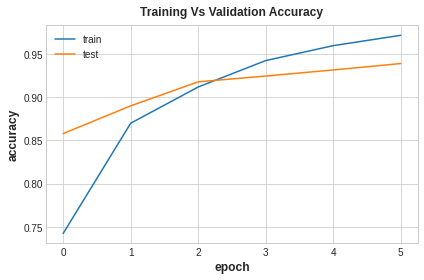

In [ ]:
# plot accuracy (train vs val)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Training Vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

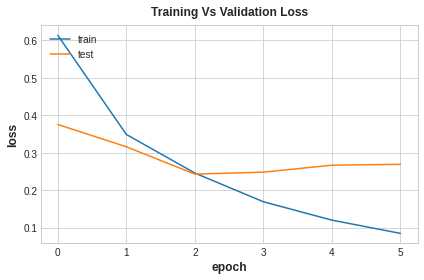

In [ ]:
# plot loss (train vs val)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Vs Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
'''history = model.fit([train_input_ids,train_attention_masks], y_train, 
                    validation_data=([val_input_ids,val_attention_masks], y_valid), 
                    epochs=3, batch_size=32)'''

# RoBERTa results

In [ ]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

76/76 [==============================] - 23s 264ms/step


In [ ]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

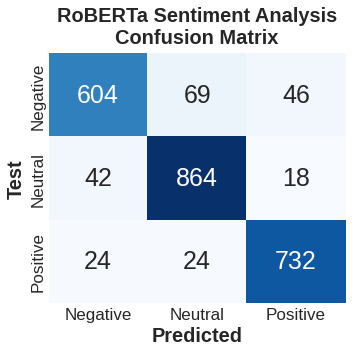

In [ ]:
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.90      0.84      0.87       719
     Neutral       0.90      0.94      0.92       924
    Positive       0.92      0.94      0.93       780

   micro avg       0.91      0.91      0.91      2423
   macro avg       0.91      0.90      0.91      2423
weighted avg       0.91      0.91      0.91      2423
 samples avg       0.91      0.91      0.91      2423



In [ ]:
print('Prediction Accuracy Roberta:', "{:.2f}".format(100*accuracy_score(y_test,y_pred_roberta))+"%")

Prediction Accuracy Roberta: 90.80%
